<a href="https://colab.research.google.com/github/sbooeshaghi/BMGP_2020/blob/main/analysis/notebooks/barcode_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
fsize=15

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
bcs = [
  list("GGAGAAGA"),
  list("CCACAATG"),
  list("CCAACCGG"),
  list("CGAAGCCC"),
  list("TCAGTCGA"),
  list("GACCAGCC"),
  list("CTCAAGGT"),
  list("CGCCGCAA"),
  list("ACCAGCCG"),
]

In [3]:
# each row is a feature barcode, each column is a nucleotide
bcs_mat = np.array(bcs)

In [4]:
err = 0.005
N = 100_000
bc_len = 8
n_bcs = len(bcs)
labels = np.arange(n_bcs)
np.random.seed(0)

In [5]:
# function, given a barcode, N, and error, return a list of mutants
def alt(barcode):
  # for each position the set of nucleotides that are not the given on
  d = set(["A", "T", "G", "C"])
  alt = [sorted(list(d.symmetric_difference(i))) for i in barcode]
  return alt

def mutate(barcode, N, err):
  barcode = list(barcode)
  bc_len = len(barcode)
  mutate_mask = np.random.rand(N,bc_len)<err

  # for each barcode for each base, the other possible nucleotide choices
  replace_opt = np.array(alt(barcode))

  # pick which of the 3 alternative nucleotides to change to
  replace_idx = np.random.choice(3, size=(N, bc_len))

  # select a single column for each row in replace_opt given by replace_idx 
  # do this for all N mutants, for each num_fb
  replace = np.array([replace_opt[np.arange(bc_len), i] for i in replace_idx]) 

  bc_mat = np.tile(barcode, (N, 1))

  # replace the nucleotides where mutate_mask is true
  bc_mat[mutate_mask] = replace[mutate_mask]
  ham = mutate_mask.sum(1)
  return bc_mat, ham

In [6]:
mutants = np.array([mutate(bc, N, err)[0] for bc in bcs])
mutants = np.concatenate(mutants, 0)
mutant_origin = np.repeat(labels, N)

# Perform correction

In [7]:
from collections import Counter

In [8]:
def distances(mutants, bcs_mat):
  # for each mutant, determine the set of hamming distances
  ham = []
  for idx, m in enumerate(mutants):    
    d = []
    for tidx, t in enumerate(bcs_mat):
      d.append((t!=m).sum())
    ham.append(d)

  ham = np.array(ham)
  return ham

In [9]:
ham = distances(mutants, bcs_mat)

In [10]:
%%time
# [ min , max)
# We want the maximum hamming after which it is ambiguous
assign = []
for h in ham:
  c = Counter(h)

  du = np.array([*c.keys()])
  du_argsort = np.argsort(du)

  one_idx, two_idx, *_ = du_argsort
  one_ham, two_ham = du[one_idx], du[two_idx]

  one_mul, two_mul = c[one_ham], c[two_ham]
  if one_mul == 1:
    min_ham = one_ham
    max_ham = two_ham 
    target = np.where(h == one_ham)[0][0]
  elif one_mul > 1:
    min_ham = one_ham - 1
    max_ham = one_ham
    target = -1

  assign.append([target, min_ham,  max_ham])
assign = np.array(assign)

CPU times: user 22 s, sys: 1.77 s, total: 23.8 s
Wall time: 21.9 s


In [11]:
assign

array([[0, 0, 4],
       [0, 0, 4],
       [0, 0, 4],
       ...,
       [8, 0, 4],
       [8, 0, 4],
       [8, 0, 4]])

In [12]:
# assigned correctly, assigned incorrectly, ambiguous

In [13]:
# barcodes that are impossible to assign for any hamming distance
ambiguous = np.equal(assign[:,0], -1)

In [14]:
# barcodes that are given the correct assignment
correct = np.equal(assign[:,0], mutant_origin)

In [15]:
mask = np.logical_and(correct, ~ambiguous)
data = Counter(np.array(assign)[:,1][mask])

In [16]:
data.items()

dict_items([(0, 864415), (1, 34931), (2, 620), (3, 7)])

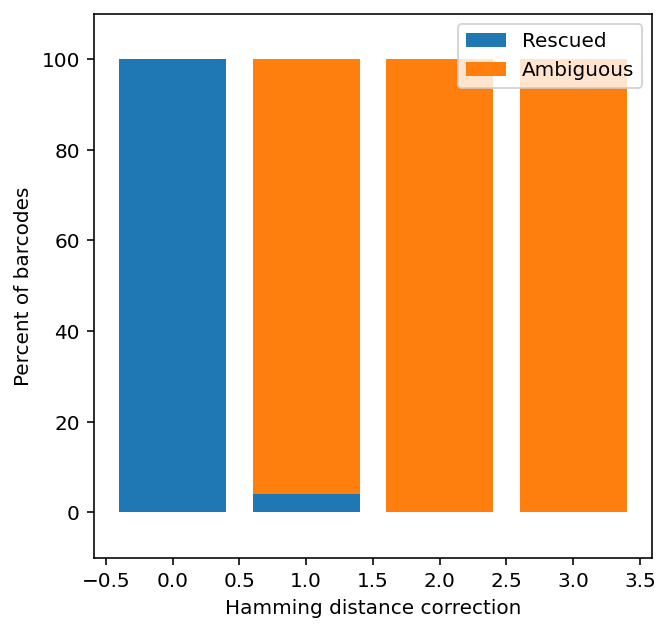

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

x = np.array([*data.keys()])
argsort = np.argsort(x)
xx = x[argsort]
y = np.array([*data.values()])[argsort]
yy = np.cumsum(y[::-1])[::-1]/(N*n_bcs)*100

amb = 100-yy
ax.bar(xx,yy, label="Rescued")
ax.bar(xx, amb, bottom=yy, label="Ambiguous")

ax.set(**{
    "xlabel": "Hamming distance correction",
    "ylabel": "Percent of barcodes",
    "ylim": (-10, 110)
})
ax.legend()
fig.show()